# Surprise Housing


The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [156]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

### Custom Functions

In [157]:
# Code to inspect dataframe and percentage missing values in rows and columns

def inspect_df(df):
    print('Shape: {0}'.format(df.shape),end='\n\n')    
    print("Duplicates: {0}".format(len(df[df.duplicated()])),end='\n\n')
    col_types=df.dtypes
    col_missing_count = df.isnull().sum()
    col_missing_pct = round(100*(df.isnull().sum()/len(df.index)),2)
    col_unique_values = df.nunique(axis=0)    
    obj = pd.DataFrame({'Columns':df.columns,'Data_Type':col_types,'Missing_Count':col_missing_count,'Missing_Percent':col_missing_pct,'Unique_Values':col_unique_values}).set_index('Columns')       
    obj = obj.reset_index()
    return obj


# Check for skewness of data in columns

def check_skewness(df):
    cols = list(df.select_dtypes(include='object').columns)    
    for i in cols:
        print("Column {0} :".format(i))
        values =  df[i].value_counts(dropna=False).to_frame().reset_index()
        values.columns = [i,'Count']
        values['Skewed %age'] = (100*df[i].value_counts(normalize=True,dropna=False)).values.round(2)
        display(values)

### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [158]:
#Reading the data from train.csv file
df= pd.read_csv('train.csv')

In [159]:
#Diplay top 5 rows from train.csv file
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [160]:
#Diplay column information and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [161]:
#Calling custom function to return Shape, Duplicates if any and data missing %, unique value counts
inspect_df(df)

Shape: (1460, 81)

Duplicates: 0



,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values
0,Id,int64,0,0.00,1460
1,MSSubClass,int64,0,0.00,15
2,MSZoning,object,0,0.00,5
3,LotFrontage,float64,259,17.74,110
4,LotArea,int64,0,0.00,1073
5,Street,object,0,0.00,2
6,Alley,object,1369,93.77,2
7,LotShape,object,0,0.00,4
8,LandContour,object,0,0.00,4
9,Utilities,object,0,0.00,2


In [162]:
#Categorical Columns which are integer needs to be converted to object type
df['MSSubClass'] = df['MSSubClass'].astype(np.object)
inspectdf = inspect_df(df)

Shape: (1460, 81)

Duplicates: 0



In [163]:
#Displaying Highly Skewed columns towards One particular Values which is also NAN
inspectdf[(inspectdf.Missing_Percent > 90)]

,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values
6,Alley,object,1369,93.77,2
72,PoolQC,object,1453,99.52,3
74,MiscFeature,object,1406,96.30,4


In [164]:
# Removing the below columns having more the 90% missing values

df.drop(['Alley', 'PoolQC','MiscFeature'], axis = 1, inplace = True)

#### Let's Check again for rest missing values

In [165]:
inspectdf[(inspectdf.Missing_Percent > 0)]

,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values
3,LotFrontage,float64,259,17.74,110
6,Alley,object,1369,93.77,2
25,MasVnrType,object,8,0.55,4
26,MasVnrArea,float64,8,0.55,327
30,BsmtQual,object,37,2.53,4
31,BsmtCond,object,37,2.53,4
32,BsmtExposure,object,38,2.60,4
33,BsmtFinType1,object,37,2.53,6
35,BsmtFinType2,object,38,2.60,6
42,Electrical,object,1,0.07,5


In [166]:
#Certain columns have NAN where the housing feature doesn't exist , so it's not a actual data miss. Imputing with values

df['FireplaceQu'].fillna('NoFireplace', inplace = True)
df['Fence'].fillna('NoFence', inplace = True)
df['BsmtQual'].fillna('NoBasement', inplace = True)
df['BsmtCond'].fillna('NoBasement', inplace = True)
df['BsmtExposure'].fillna('NoBasement', inplace = True)
df['BsmtFinType1'].fillna('NoBasement', inplace = True)
df['BsmtFinType2'].fillna('NoBasement', inplace = True)
df['FireplaceQu'].fillna('NoFireplace', inplace = True)
df['GarageType'].fillna('NoGarage', inplace = True)
df['GarageFinish'].fillna('NoGarage', inplace = True)
df['GarageQual'].fillna('NoGarage', inplace = True)
df['GarageCond'].fillna('NoGarage', inplace = True)

In [167]:
inspectdf = inspect_df(df)
inspectdf[(inspectdf.Missing_Percent > 0)]

Shape: (1460, 78)

Duplicates: 0



,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values
3,LotFrontage,float64,259,17.74,110
24,MasVnrType,object,8,0.55,4
25,MasVnrArea,float64,8,0.55,327
41,Electrical,object,1,0.07,5
58,GarageYrBlt,float64,81,5.55,97


In [168]:
# Above columns have actual missing values
# For LotFrontage we can't remove 259 records out of 1460 which will be huge data loss.
df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [169]:
#Imputing Mean value to LotFrontage

df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)

In [170]:
#Removing Rows where MasVnrType is null

df = df[~df['MasVnrType'].isnull()]
df = df[~df['Electrical'].isnull()]

In [171]:
inspectdf = inspect_df(df)
inspectdf[(inspectdf.Missing_Percent > 0)]

Shape: (1451, 78)

Duplicates: 0



,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values
58,GarageYrBlt,float64,81,5.58,97


In [172]:
#Let's check what is the value of GarageType field where AgeOfGarage is NAN.

(df[df['GarageYrBlt'].isnull()].GarageType == 'NoGarage').sum()

81

In [173]:
#We notice that GarageYrBlt is null where records have no Garage, let create a new feature as AgeOfGarage from GarageYrBlt

df['AgeOfGarage'] = 2020 - df['GarageYrBlt']

In [174]:
# For NAN values we can fill the value as 0 for "NoGarage" and remove GarageYrBlt feature.

df['AgeOfGarage'].fillna(0, inplace = True)
df.drop(['GarageYrBlt'], axis = 1, inplace = True)

In [175]:
inspectdf = inspect_df(df)
inspectdf[(inspectdf.Missing_Percent > 0)]

Shape: (1451, 78)

Duplicates: 0



,Columns,Data_Type,Missing_Count,Missing_Percent,Unique_Values


#### We notice that there no more missing data

In [176]:
#Let's convert other year coumns to age as well and delete the year columns
df['YrSold_Age'] = 2020 - df['YrSold']
df['YearBuilt_Age'] = 2020 - df['YearBuilt']
df['YearRemodAdd_Age'] = 2020 - df['YearRemodAdd']

df.drop(['YrSold','YearBuilt','YearRemodAdd'], axis = 1, inplace = True)

In [177]:
# Check value counts of this columns
check_skewness(df)

Column MSSubClass :


,MSSubClass,Count,Skewed %age
0,20,532,36.66
1,60,296,20.40
2,50,144,9.92
3,120,86,5.93
4,30,69,4.76
5,160,63,4.34
6,70,60,4.14
7,80,57,3.93
8,90,52,3.58
9,190,30,2.07


Column MSZoning :


,MSZoning,Count,Skewed %age
0,RL,1145,78.91
1,RM,218,15.02
2,FV,62,4.27
3,RH,16,1.10
4,C (all),10,0.69


Column Street :


,Street,Count,Skewed %age
0,Pave,1445,99.59
1,Grvl,6,0.41


Column LotShape :


,LotShape,Count,Skewed %age
0,Reg,918,63.27
1,IR1,482,33.22
2,IR2,41,2.83
3,IR3,10,0.69


Column LandContour :


,LandContour,Count,Skewed %age
0,Lvl,1302,89.73
1,Bnk,63,4.34
2,HLS,50,3.45
3,Low,36,2.48


Column Utilities :


,Utilities,Count,Skewed %age
0,AllPub,1450,99.93
1,NoSeWa,1,0.07


Column LotConfig :


,LotConfig,Count,Skewed %age
0,Inside,1045,72.02
1,Corner,262,18.06
2,CulDSac,93,6.41
3,FR2,47,3.24
4,FR3,4,0.28


Column LandSlope :


,LandSlope,Count,Skewed %age
0,Gtl,1373,94.62
1,Mod,65,4.48
2,Sev,13,0.90


Column Neighborhood :


,Neighborhood,Count,Skewed %age
0,NAmes,225,15.51
1,CollgCr,149,10.27
2,OldTown,113,7.79
3,Edwards,100,6.89
4,Somerst,83,5.72
5,Gilbert,78,5.38
6,NridgHt,76,5.24
7,Sawyer,74,5.10
8,NWAmes,73,5.03
9,SawyerW,58,4.00


Column Condition1 :


,Condition1,Count,Skewed %age
0,Norm,1251,86.22
1,Feedr,81,5.58
2,Artery,48,3.31
3,RRAn,26,1.79
4,PosN,19,1.31
5,RRAe,11,0.76
6,PosA,8,0.55
7,RRNn,5,0.34
8,RRNe,2,0.14


Column Condition2 :


,Condition2,Count,Skewed %age
0,Norm,1436,98.97
1,Feedr,6,0.41
2,Artery,2,0.14
3,RRNn,2,0.14
4,PosN,2,0.14
5,PosA,1,0.07
6,RRAe,1,0.07
7,RRAn,1,0.07


Column BldgType :


,BldgType,Count,Skewed %age
0,1Fam,1212,83.53
1,TwnhsE,113,7.79
2,Duplex,52,3.58
3,Twnhs,43,2.96
4,2fmCon,31,2.14


Column HouseStyle :


,HouseStyle,Count,Skewed %age
0,1Story,721,49.69
1,2Story,442,30.46
2,1.5Fin,154,10.61
3,SLvl,64,4.41
4,SFoyer,37,2.55
5,1.5Unf,14,0.96
6,2.5Unf,11,0.76
7,2.5Fin,8,0.55


Column RoofStyle :


,RoofStyle,Count,Skewed %age
0,Gable,1133,78.08
1,Hip,285,19.64
2,Flat,13,0.90
3,Gambrel,11,0.76
4,Mansard,7,0.48
5,Shed,2,0.14


Column RoofMatl :


,RoofMatl,Count,Skewed %age
0,CompShg,1425,98.21
1,Tar&Grv,11,0.76
2,WdShngl,6,0.41
3,WdShake,5,0.34
4,Metal,1,0.07
5,Membran,1,0.07
6,ClyTile,1,0.07
7,Roll,1,0.07


Column Exterior1st :


,Exterior1st,Count,Skewed %age
0,VinylSd,509,35.08
1,HdBoard,222,15.30
2,MetalSd,220,15.16
3,Wd Sdng,205,14.13
4,Plywood,108,7.44
5,CemntBd,59,4.07
6,BrkFace,50,3.45
7,WdShing,26,1.79
8,Stucco,25,1.72
9,AsbShng,20,1.38


Column Exterior2nd :


,Exterior2nd,Count,Skewed %age
0,VinylSd,498,34.32
1,MetalSd,214,14.75
2,HdBoard,207,14.27
3,Wd Sdng,197,13.58
4,Plywood,142,9.79
5,CmentBd,58,4.00
6,Wd Shng,38,2.62
7,Stucco,26,1.79
8,BrkFace,25,1.72
9,AsbShng,20,1.38


Column MasVnrType :


,MasVnrType,Count,Skewed %age
0,None,863,59.48
1,BrkFace,445,30.67
2,Stone,128,8.82
3,BrkCmn,15,1.03


Column ExterQual :


,ExterQual,Count,Skewed %age
0,TA,905,62.37
1,Gd,481,33.15
2,Ex,51,3.51
3,Fa,14,0.96


Column ExterCond :


,ExterCond,Count,Skewed %age
0,TA,1273,87.73
1,Gd,146,10.06
2,Fa,28,1.93
3,Ex,3,0.21
4,Po,1,0.07


Column Foundation :


,Foundation,Count,Skewed %age
0,PConc,638,43.97
1,CBlock,634,43.69
2,BrkTil,146,10.06
3,Slab,24,1.65
4,Stone,6,0.41
5,Wood,3,0.21


Column BsmtQual :


,BsmtQual,Count,Skewed %age
0,TA,648,44.66
1,Gd,611,42.11
2,Ex,120,8.27
3,NoBasement,37,2.55
4,Fa,35,2.41


Column BsmtCond :


,BsmtCond,Count,Skewed %age
0,TA,1303,89.80
1,Gd,64,4.41
2,Fa,45,3.10
3,NoBasement,37,2.55
4,Po,2,0.14


Column BsmtExposure :


,BsmtExposure,Count,Skewed %age
0,No,945,65.13
1,Av,221,15.23
2,Gd,133,9.17
3,Mn,114,7.86
4,NoBasement,38,2.62


Column BsmtFinType1 :


,BsmtFinType1,Count,Skewed %age
0,Unf,427,29.43
1,GLQ,413,28.46
2,ALQ,220,15.16
3,BLQ,148,10.20
4,Rec,132,9.10
5,LwQ,74,5.10
6,NoBasement,37,2.55


Column BsmtFinType2 :


,BsmtFinType2,Count,Skewed %age
0,Unf,1247,85.94
1,Rec,54,3.72
2,LwQ,46,3.17
3,NoBasement,38,2.62
4,BLQ,33,2.27
5,ALQ,19,1.31
6,GLQ,14,0.96


Column Heating :


,Heating,Count,Skewed %age
0,GasA,1419,97.79
1,GasW,18,1.24
2,Grav,7,0.48
3,Wall,4,0.28
4,OthW,2,0.14
5,Floor,1,0.07


Column HeatingQC :


,HeatingQC,Count,Skewed %age
0,Ex,734,50.59
1,TA,427,29.43
2,Gd,240,16.54
3,Fa,49,3.38
4,Po,1,0.07


Column CentralAir :


,CentralAir,Count,Skewed %age
0,Y,1356,93.45
1,N,95,6.55


Column Electrical :


,Electrical,Count,Skewed %age
0,SBrkr,1326,91.39
1,FuseA,94,6.48
2,FuseF,27,1.86
3,FuseP,3,0.21
4,Mix,1,0.07


Column KitchenQual :


,KitchenQual,Count,Skewed %age
0,TA,734,50.59
1,Gd,579,39.90
2,Ex,99,6.82
3,Fa,39,2.69


Column Functional :


,Functional,Count,Skewed %age
0,Typ,1352,93.18
1,Min2,34,2.34
2,Min1,31,2.14
3,Mod,15,1.03
4,Maj1,13,0.90
5,Maj2,5,0.34
6,Sev,1,0.07


Column FireplaceQu :


,FireplaceQu,Count,Skewed %age
0,NoFireplace,685,47.21
1,Gd,378,26.05
2,TA,311,21.43
3,Fa,33,2.27
4,Ex,24,1.65
5,Po,20,1.38


Column GarageType :


,GarageType,Count,Skewed %age
0,Attchd,863,59.48
1,Detchd,387,26.67
2,BuiltIn,86,5.93
3,NoGarage,81,5.58
4,Basment,19,1.31
5,CarPort,9,0.62
6,2Types,6,0.41


Column GarageFinish :


,GarageFinish,Count,Skewed %age
0,Unf,605,41.70
1,RFn,418,28.81
2,Fin,347,23.91
3,NoGarage,81,5.58


Column GarageQual :


,GarageQual,Count,Skewed %age
0,TA,1302,89.73
1,NoGarage,81,5.58
2,Fa,48,3.31
3,Gd,14,0.96
4,Po,3,0.21
5,Ex,3,0.21


Column GarageCond :


,GarageCond,Count,Skewed %age
0,TA,1317,90.76
1,NoGarage,81,5.58
2,Fa,35,2.41
3,Gd,9,0.62
4,Po,7,0.48
5,Ex,2,0.14


Column PavedDrive :


,PavedDrive,Count,Skewed %age
0,Y,1331,91.73
1,N,90,6.20
2,P,30,2.07


Column Fence :


,Fence,Count,Skewed %age
0,NoFence,1170,80.63
1,MnPrv,157,10.82
2,GdPrv,59,4.07
3,GdWo,54,3.72
4,MnWw,11,0.76


Column SaleType :


,SaleType,Count,Skewed %age
0,WD,1261,86.91
1,New,119,8.20
2,COD,43,2.96
3,ConLD,9,0.62
4,ConLw,5,0.34
5,ConLI,5,0.34
6,CWD,4,0.28
7,Oth,3,0.21
8,Con,2,0.14


Column SaleCondition :


,SaleCondition,Count,Skewed %age
0,Normal,1193,82.22
1,Partial,122,8.41
2,Abnorml,101,6.96
3,Family,20,1.38
4,Alloca,11,0.76
5,AdjLand,4,0.28


In [178]:
#Let's remove highly skewed columns such as Street,Utilities,LandSlope ,Condition2,RoofMatl ,Heating and the Id column too
df.drop(['Street','Utilities','LandSlope','Condition2','RoofMatl','Heating','Id'], axis = 1, inplace = True)

In [179]:
round(100*(1460-df.shape[0])/1460,2)

0.62

We lost 0.6% rows in missing value treatment which is acceptable.

## 2. Exploratory Data Analysis

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case

In [180]:
#Listing out all numeric features
numeric_df = df.select_dtypes(include=['float64', 'int64'])

### Univariate Analysis

#### Continuous variables

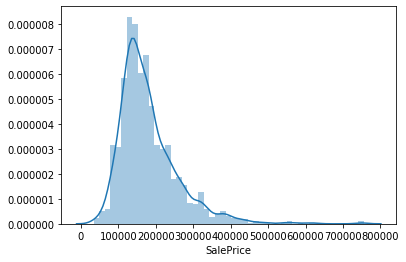

In [181]:
#Plotting target column skewness using distplot
sns.distplot(df['SalePrice'])
plt.show()

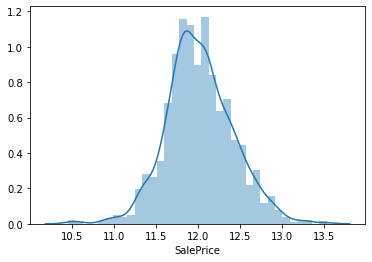

In [182]:
#Performing Log transformation to remove skewness from the traget variable.
sns.distplot(np.log(df['SalePrice']))
plt.show()

In [183]:
#Removing skewness using Log transformation
df['SalePrice'] = np.log(df['SalePrice'])

In [184]:
#Other Continuous variables
df.describe(percentiles = [.25,.5,.75,.90,.95,.99])

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfGarage,YrSold_Age,YearBuilt_Age,YearRemodAdd_Age
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.00000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,70.031592,10507.808408,6.093728,5.579600,103.75672,442.274983,46.838043,567.197105,1056.310131,1161.551344,346.742247,5.880772,1514.174363,0.423846,0.057891,1.562371,0.381116,2.866988,1.046175,6.516885,0.612681,1.764990,472.525155,94.412819,46.422467,21.952447,3.430737,15.154376,2.776017,43.758787,6.319090,12.022388,39.321847,12.184700,48.907650,35.239835
std,22.040937,9992.987081,1.381467,1.113415,181.10815,455.369276,161.777324,442.209192,437.914609,385.002532,436.453277,48.771560,525.799521,0.518842,0.239449,0.550301,0.502574,0.815086,0.219571,1.626576,0.643443,0.748728,214.171752,125.436852,66.060150,61.108223,29.406940,55.917522,40.301212,497.648467,2.700353,0.399502,25.823014,1.329376,30.190266,20.651334
min,21.000000,1300.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.460242,0.000000,10.000000,10.000000,10.000000
25%,60.000000,7537.500000,5.000000,5.000000,0.00000,0.000000,0.000000,222.000000,795.000000,882.000000,0.000000,0.000000,1128.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,327.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,11.774520,17.000000,11.000000,20.000000,16.000000
50%,70.049958,9477.000000,6.000000,5.000000,0.00000,381.000000,0.000000,479.000000,991.000000,1086.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,11.998433,36.000000,12.000000,48.000000,27.000000
75%,79.000000,11600.000000,7.000000,6.000000,166.00000,707.000000,0.000000,808.000000,1297.500000,1391.000000,728.000000,0.000000,1776.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,12.273731,58.000000,13.000000,66.000000,54.000000
90%,92.000000,14375.000000,8.000000,7.000000,335.00000,1064.000000,119.000000,1232.000000,1602.000000,1680.000000,954.000000,0.000000,2158.000000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,9.000000,1.000000,3.000000,757.000000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,12.535376,72.000000,14.000000,96.000000,70.000000
95%,104.000000,17308.500000,8.000000,8.000000,456.00000,1272.000000,398.000000,1468.000000,1749.000000,1827.000000,1141.500000,0.000000,2464.000000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000,10.000000,2.000000,3.000000,849.000000,335.000000,173.000000,180.000000,0.000000,160.000000,0.000000,0.000000,11.000000,12.694076,90.000000,14.000000,104.000000,70.000000
99%,137.500000,37802.000000,10.000000,9.000000,792.00000,1572.500000,832.000000,1797.500000,2155.500000,2212.000000,1420.000000,360.000000,3126.000000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,11.000000,2.000000,3.000000,1004.500000,506.000000,286.000000,261.500000,168.000000,268.50000

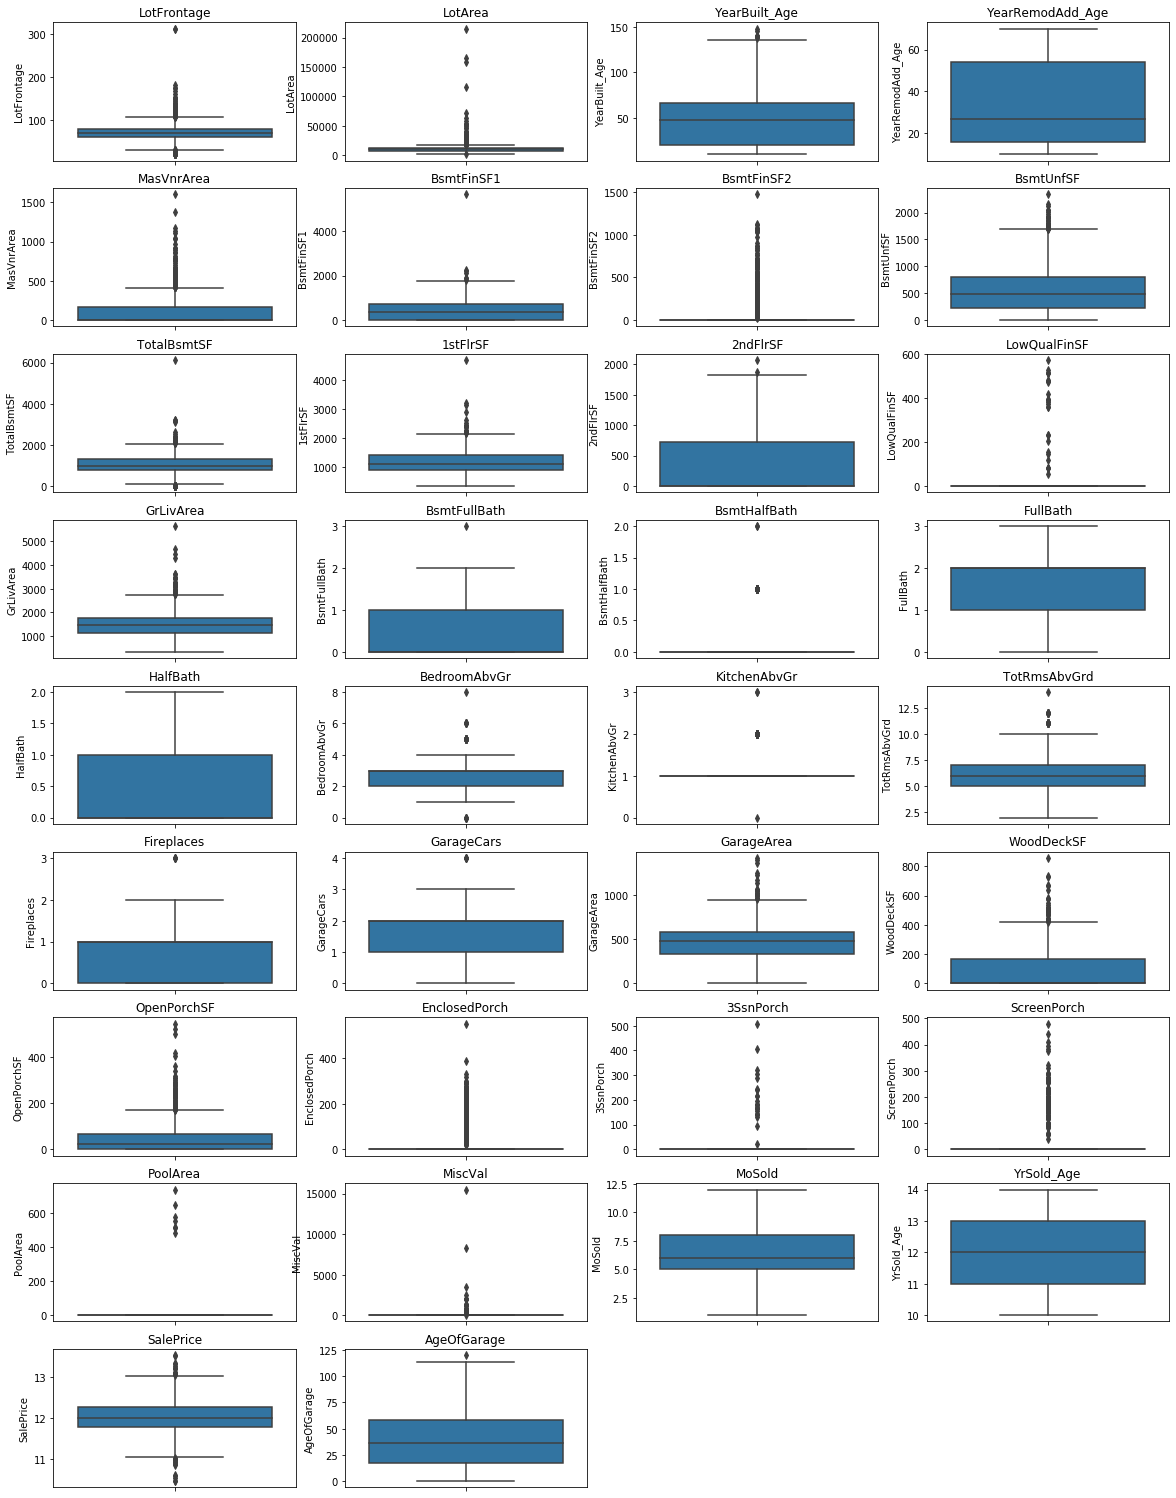

In [185]:
# Plot boxplots for numerical variables

columns = ['LotFrontage','LotArea','YearBuilt_Age','YearRemodAdd_Age','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold_Age','SalePrice','AgeOfGarage']

plt.figure(figsize = (20,30))
indx = 1
for col in columns:
    plt.subplot(10,4,indx)
    sns.boxplot(y=df[col])
    plt.title(col)
    indx += 1
plt.show()

#### We can notice a lot of columns have outliers, we are choosing not to remove these outliers. 

##### We would want to predict the price as per original values.

#### Categorical variables

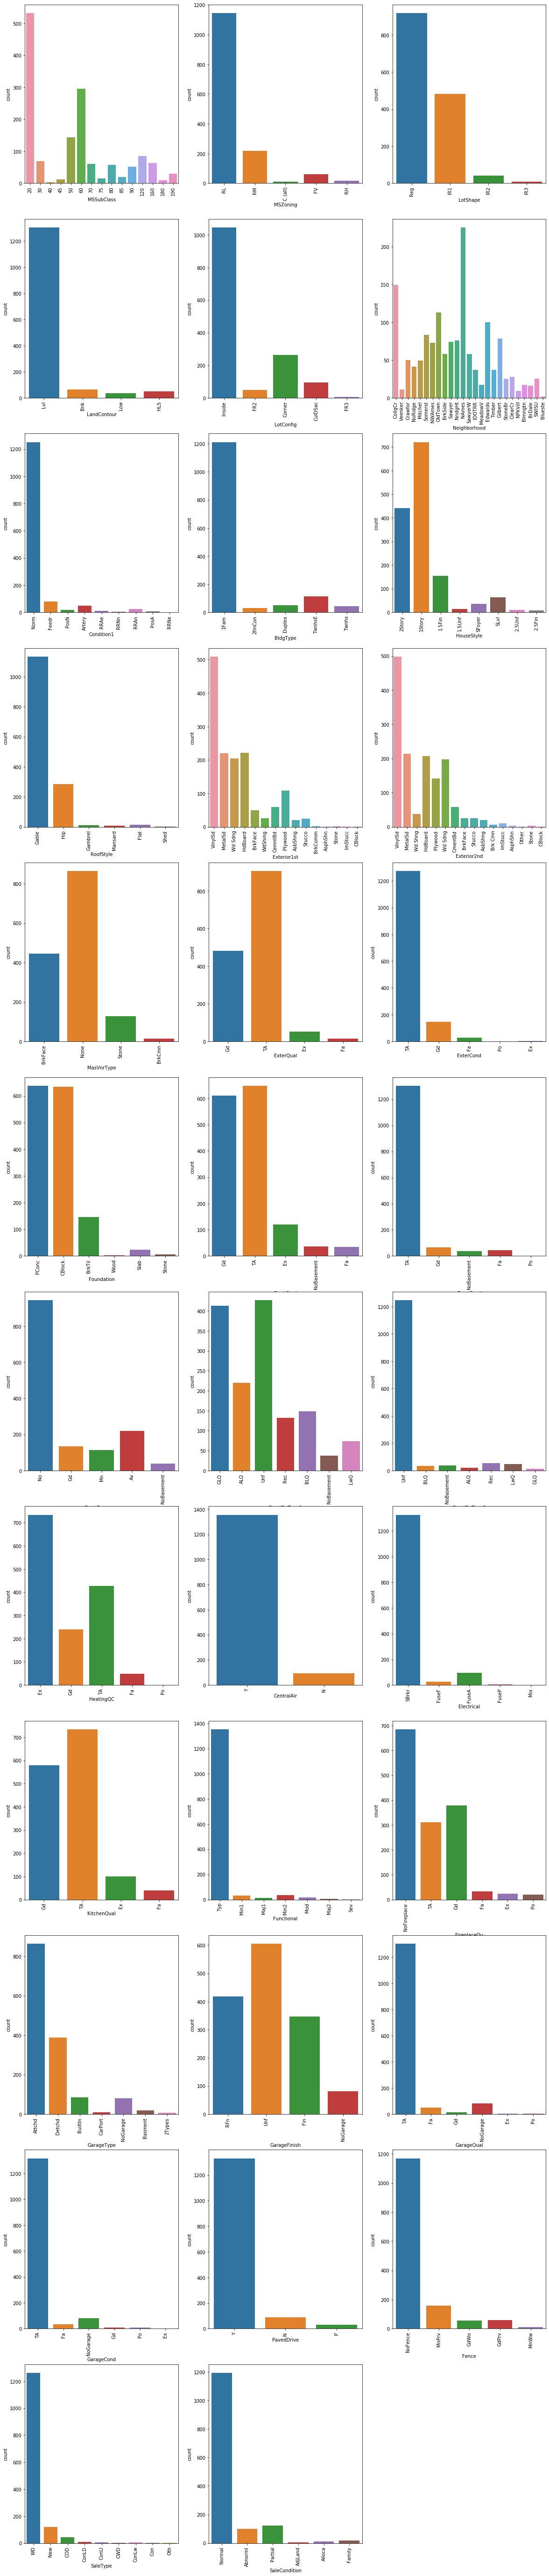

In [186]:
cols = list(df.select_dtypes(include='object').columns)
plt.figure(figsize = (20,100))
indx = 1
for col in cols:
    plt.subplot(12,3,indx)
    sns.countplot(x=col, data = df)
    indx += 1
    plt.xticks(rotation=90)
plt.show()

#### Insights: From the count plots we can observe different categorical variables and their distribution of data. Few details are

1. MSSubClass: There are lot of houses with 1-STORY 1946 & NEWER ALL STYLES
2. MSZoning : There are lot of houses with Residential Low Density area
3. LotShape : Most of the houses are Regular in shape and Near Flat/Level.
4. Neighborhood : Most of the houses are in North Ames
5. Most of the houses are Adjacent to arterial street and Single-family Detached type, One story.
6. Most of the houses type of roof are Gable.	

### Bivariate Analysis
#### Continuous variables

In [187]:
# correlation matrix
cor = numeric_df.corr()
cor

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfGarage,YrSold_Age,YearBuilt_Age,YearRemodAdd_Age
LotFrontage,1.000000,0.306918,0.232694,-0.052502,0.179774,0.217204,0.043693,0.119975,0.363155,0.415154,0.073401,0.037037,0.368349,0.092442,-0.006234,0.178951,0.048887,0.236988,-0.005681,0.319745,0.236243,0.268877,0.323352,0.076028,0.135262,0.010145,0.062581,0.038007,0.181349,0.001244,0.009554,0.333343,-0.023421,-0.007669,-0.117313,-0.082311
LotArea,0.306918,1.000000,0.106305,-0.002297,0.104141,0.213081,0.111674,-0.004250,0.258538,0.295977,0.052979,0.004897,0.261152,0.157695,0.048365,0.122526,0.016364,0.117788,-0.024708,0.188012,0.269677,0.154761,0.180767,0.173170,0.086278,-0.023114,0.020568,0.043498,0.077885,0.038221,0.003177,0.264668,0.049614,0.012969,-0.015708,-0.015190
OverallQual,0.232694,0.106305,1.000000,-0.090940,0.411699,0.236421,-0.058211,0.309461,0.536836,0.476645,0.299021,-0.030071,0.594431,0.108108,-0.039348,0.552939,0.272338,0.106013,-0.184799,0.430817,0.400090,0.600055,0.560502,0.240728,0.303215,-0.113176,0.030972,0.066271,0.065720,-0.031183,0.068514,0.790085,-0.383897,0.025116,-0.572129,-0.550499
OverallCond,-0.052502,-0.002297,-0.090940,1.000000,-0.128333,-0.042292,0.039234,-0.137104,-0.167932,-0.139260,0.027720,0.025099,-0.076631,-0.051877,0.117217,-0.190170,-0.061030,0.014334,-0.081338,-0.055864,-0.020470,-0.184777,-0.151204,-0.004514,-0.031432,0.074612,0.025123,0.053925,-0.002254,0.068617,-0.004210,-0.076361,0.287966,-0.043487,0.376557,-0.075545
MasVnrArea,0.179774,0.104141,0.411699,-0.128333,1.000000,0.264469,-0.072443,0.114298,0.363667,0.344255,0.174874,-0.069127,0.390818,0.085017,0.026581,0.277238,0.202058,0.102898,-0.037698,0.280839,0.248800,0.364381,0.372990,0.159754,0.125461,-0.110363,0.018752,0.061367,0.011697,-0.029854,-0.006159,0.477486,-0.188296,0.008147,-0.316345,-0.180136
BsmtFinSF1,0.217204,0.213081,0.236421,-0.042292,0.264469,1.000000,-0.049498,-0.496605,0.520098,0.442838,-0.135330,-0.064447,0.205944,0.647159,0.068473,0.056371,0.002778,-0.105617,-0.086643,0.044288,0.257828,0.222531,0.295374,0.205447,0.107279,-0.105887,0.026926,0.063139,0.141361,0.003852,-0.016387,0.383995,-0.099423,-0.016969,-0.250209,-0.128422
BsmtFinSF2,0.043693,0.111674,-0.058211,0.039234,-0.072443,-0.049498,1.000000,-0.209806,0.106092,0.098654,-0.099445,0.014596,-0.008956,0.160068,0.070547,-0.075366,-0.031261,-0.015990,-0.040503,-0.035155,0.047318,-0.037494,-0.017641,0.067684,0.004155,0.036680,-0.030211,0.088430,0.041597,0.004784,-0.014977,-0.010350,0.094439,-0.031880,0.047609,0.066485
BsmtUnfSF,0.119975,-0.004250,0.309461,-0.137104,0.114298,-0.496605,-0.209806,1.000000,0.415900,0.318053,0.006341,0.028245,0.240770,-0.422586,-0.096020,0.288771,-0.038740,0.165986,0.028609,0.250789,0.052743,0.214645,0.183865,-0.004180,0.130046,-0.003787,0.020825,-0.012585,-0.035168,-0.023884,0.033297,0.215707,-0.161840,0.040340,-0.150218,-0.182219
TotalBsmtSF,0.363155,0.258538,0.536836,-0.167932,0.363667,0.520098,0.106092,0.415900,1.000000,0.818107,-0.171058,-0.033102,0.453975,0.305356,0.000302,0.322378,-0.047779,0.051880,-0.076170,0.286315,0.338845,0.434300,0.486298,0.234420,0.244411,-0.100381,0.037867,0.085616,0.126850,-0.018345,0.011051,0.613299,-0.231925,0.011313,-0.394285,-0.292985
1stFlrSF,0.415154,0.295977,0.476645,-0.139260,0.344255,0.442838,0.098654,0.318053,0.818107,1.000000,-0.198812,-0.014007,0.565895,0.242462,0.002646,0.378637,-0.118775,0.128499,0.058601,0.410612,0.409939,0.439963,0.490839,0.238824,0.210229,-0.072904,0.056838,0.090177,0.132670,-0.021003,0.030806,0.606969,-0.155772,0.008965,-0.285655,-0.243464


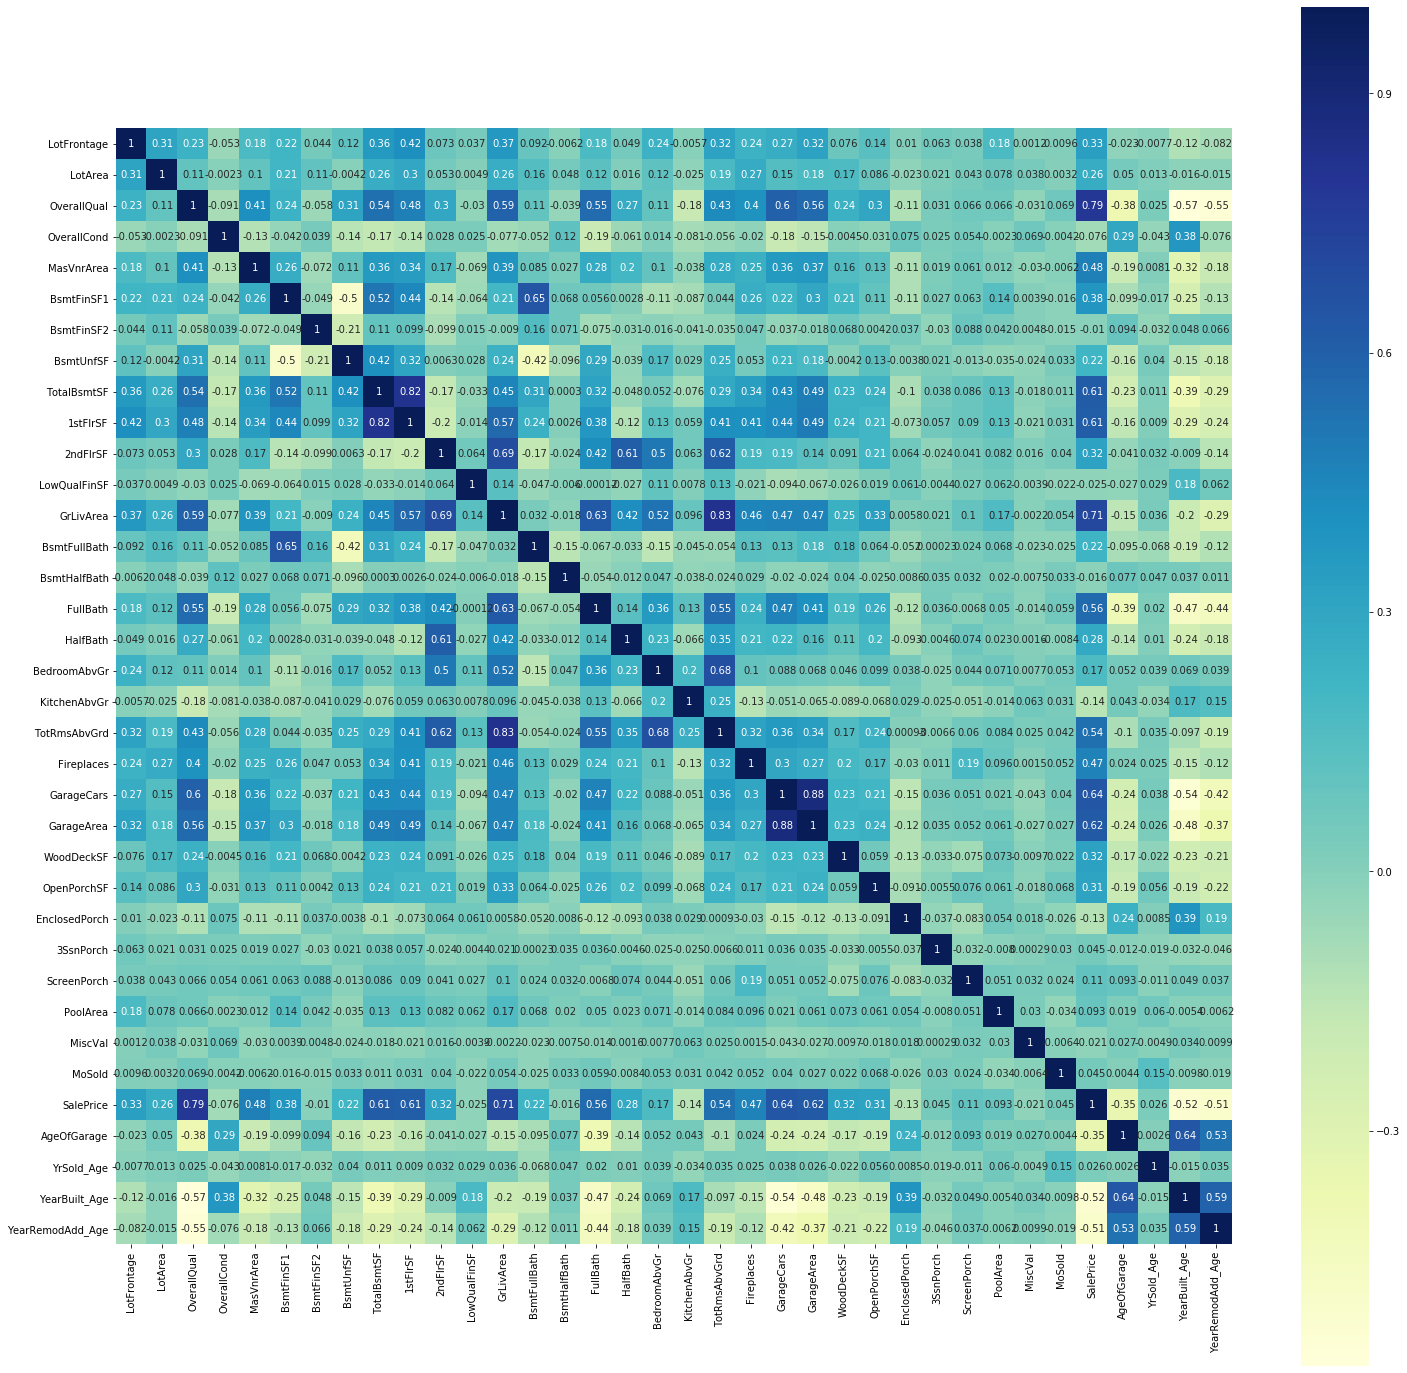

In [188]:
# create a heatmap for correlation
plt.figure(figsize = (25,25))
ax = sns.heatmap(cor,cmap="YlGnBu", annot=True,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation= 0) 
plt.show()

#### Insights: From the correlation matrix we can see a strong correlation between SalePrice and certain features which can help us explain the data while building model.

1. OverallQual   - 0.82
2. TotalBsmtSF   - 0.61
3. GarageCars    - 0.68
4. GarageArea    - 0.65
5. YearBuilt_Age - -0.59

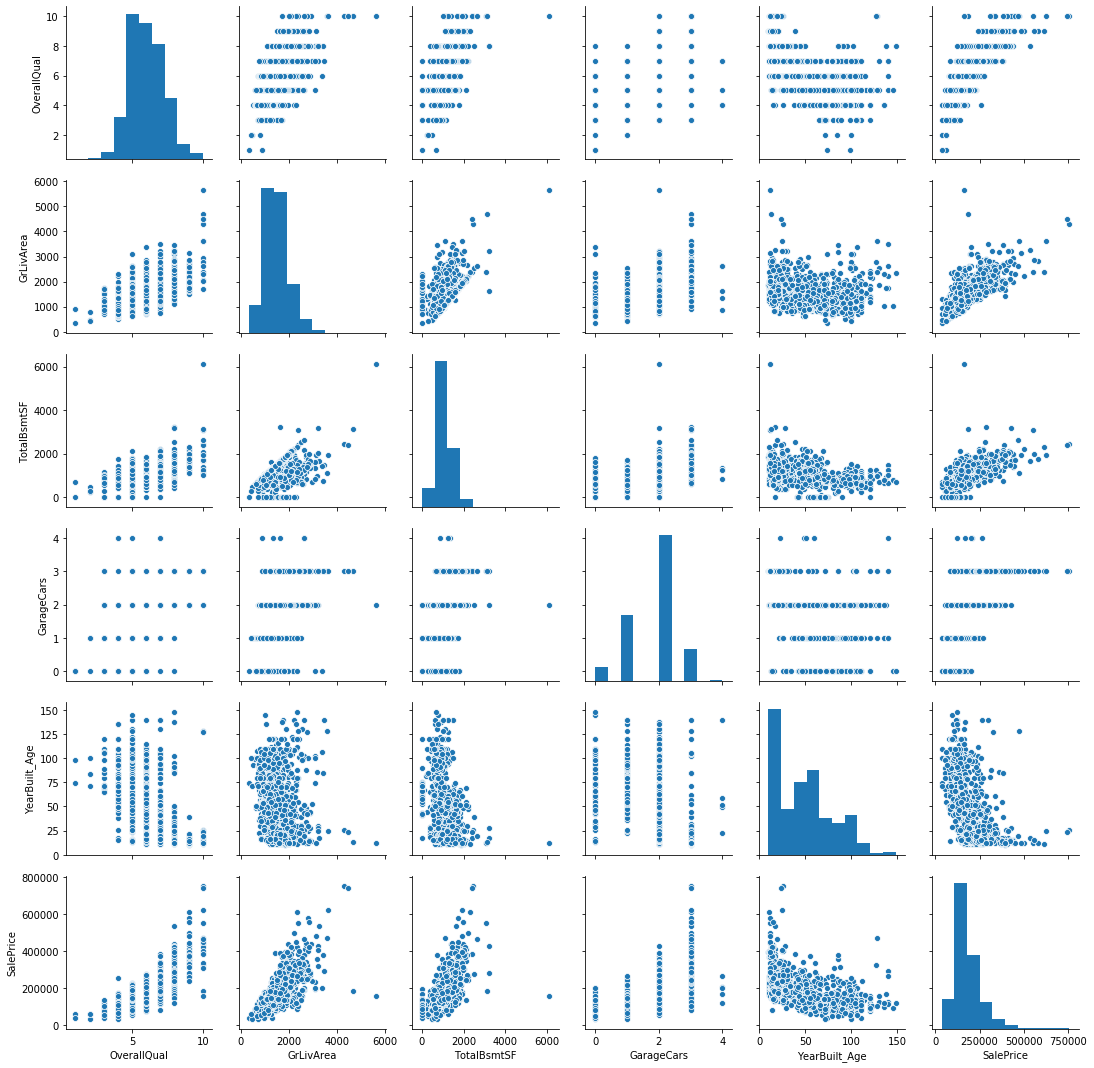

In [189]:
#Pair Plot of few continuous columns which have a linear relationship 
sns.pairplot(numeric_df[['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','YearBuilt_Age','SalePrice']])
plt.show()

#### Insights: Since we can see linear relationship between SalesPrice and few other continuous variables we can certainly apply Linear Regression
- More Overall Quality more is the SalePrice
- More LivArea more is the SalePrice
- More Total Basement Area more is the SalePrice
- Old Houses have less SalePrice.

## Dummy Features Creation

In [190]:
cols = list(df.select_dtypes(include='object').columns)

# Drop the first dummy variable in these columns
dummies = pd.get_dummies(df[cols], drop_first=True)
df = pd.concat([df,dummies],axis=1)

df.drop(cols, axis = 1, inplace = True)

In [191]:
df.shape

(1451, 241)

In [192]:
df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfGarage,YrSold_Age,YearBuilt_Age,YearRemodAdd_Age,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NoBasement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBasement,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,12.247694,17.0,12,17,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

## Scaling the data

In [193]:
# rescale the features
# scaling (the df is converted to a numpy array)

cols = df.columns
df_scaled = pd.DataFrame(scale(df))
df_scaled.columns = cols
df_scaled.columns


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=241)

In [194]:
df_scaled.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfGarage,YrSold_Age,YearBuilt_Age,YearRemodAdd_Age,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NoBasement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBasement,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NoGarage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_NoGarage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NoFence,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.228363,-0.205996,0.656247,-0.520740,0.509503,0.579345,-0.289621,-0.943764,-0.457576,-0.793908,1.162628,-0.120619,0.372562,1.110846,-0.2418

## 3. Model Building

## Splitting Into Train and Test

In [195]:
# train-test 70-30 split
df_train, df_test = train_test_split(df,train_size = 0.7,test_size = 0.3,random_state = 100)

In [196]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

### Feature selection using RFE

Now, we have 241 predictor features. To build the model using RFE, we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm. 

Number of features to be used in the model is a **hyperparameter**.

In [197]:
linreg = LinearRegression()

In [198]:
# Run RFE with 30 variables

rfe = RFE(linreg,30)
rfe = rfe.fit(X_train,y_train)

In [199]:
rfe.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [200]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('LotFrontage', False, 191),
 ('LotArea', False, 208),
 ('OverallQual', True, 1),
 ('OverallCond', False, 48),
 ('MasVnrArea', False, 206),
 ('BsmtFinSF1', False, 197),
 ('BsmtFinSF2', False, 198),
 ('BsmtUnfSF', False, 199),
 ('TotalBsmtSF', False, 196),
 ('1stFlrSF', False, 174),
 ('2ndFlrSF', False, 173),
 ('LowQualFinSF', False, 172),
 ('GrLivArea', False, 171),
 ('BsmtFullBath', False, 11),
 ('BsmtHalfBath', False, 155),
 ('FullBath', True, 1),
 ('HalfBath', False, 6),
 ('BedroomAbvGr', False, 32),
 ('KitchenAbvGr', False, 127),
 ('TotRmsAbvGrd', False, 177),
 ('Fireplaces', False, 20),
 ('GarageCars', True, 1),
 ('GarageArea', False, 207),
 ('WoodDeckSF', False, 204),
 ('OpenPorchSF', False, 205),
 ('EnclosedPorch', False, 202),
 ('3SsnPorch', False, 195),
 ('ScreenPorch', False, 200),
 ('PoolArea', False, 203),
 ('MiscVal', False, 209),
 ('MoSold', False, 186),
 ('AgeOfGarage', False, 193),
 ('YrSold_Age', False, 182),
 ('YearBuilt_Age', False, 188),
 ('YearRemodAdd_Age', False

In [201]:
# Columns selected by RFE

col = X_train.columns[rfe.support_]
col

Index(['OverallQual', 'FullBath', 'GarageCars', 'MSSubClass_30',
       'MSSubClass_40', 'MSSubClass_160', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_Crawfor',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'Neighborhood_Veenker', 'RoofStyle_Shed', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_Stone', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_NoBasement', 'BsmtCond_Po',
       'BsmtExposure_Gd', 'BsmtFinType1_NoBasement', 'HeatingQC_Po',
       'CentralAir_Y', 'Functional_Maj2', 'GarageType_CarPort'],
      dtype='object')

In [202]:
X_train = X_train[col]

## Ridge and Lasso Regression

## 1. Ridge Regression

In [203]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [204]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010192,0.001936,0.004000,0.001549,0.0001,{'alpha': 0.0001},-0.139891,-0.116515,-0.129141,-0.121247,-0.123036,-0.125966,0.008052,8,-0.117560,-0.123019,-0.119980,-0.121939,-0.120969,-0.120693,0.001863
1,0.008795,0.001938,0.002798,0.000748,0.001,{'alpha': 0.001},-0.139890,-0.116518,-0.129136,-0.121255,-0.123030,-0.125966,0.008050,7,-0.117561,-0.123020,-0.119983,-0.121941,-0.120973,-0.120696,0.001863
2,0.007396,0.001019,0.002598,0.000799,0.01,{'alpha': 0.01},-0.139876,-0.116552,-0.129089,-0.121325,-0.122964,-0.125961,0.008030,5,-0.117574,-0.123031,-0.120014,-0.121960,-0.121011,-0.120718,0.001863
3,0.006796,0.001166,0.002799,0.000749,0.05,{'alpha': 0.05},-0.139817,-0.116690,-0.128889,-0.121621,-0.122703,-0.125944,0.007949,4,-0.117640,-0.123076,-0.120142,-0.122041,-0.121174,-0.120815,0.001859
4,0.006996,0.001095,0.002798,0.000748,0.1,{'alpha': 0.1},-0.139750,-0.116850,-0.128660,-0.121954,-0.122429,-0.125929,0.007861,2,-0.117717,-0.123128,-0.120291,-0.122130,-0.121358,-0.120925,0.001854


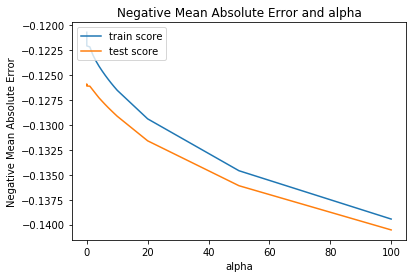

In [205]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [206]:
alpha = 0.0001
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

# predict prices of X_train
y_train_pred = ridge.predict(X_train)
r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2)

0.8380159855427354


#### Ridge Regression - We got a R-squared value of 0.84 for Train dataset

#### Residual analysis 
To validate assumptions of the model, and hence the reliability for inference

#### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

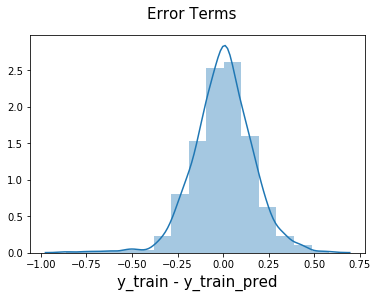

In [207]:
res = (y_train - y_train_pred)

fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

The residuals are little left skewed but following the normally distributed with a mean almost 0.

### Predictions on the Test Set

In [208]:
X_test = X_test[col]

# predict prices of X_test
y_test_pred = ridge.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_test_pred)
print(r2)

0.8257704048772092


#### Ridge Regression - We got a R-squared value of 0.83 for Test dataset

## 2. Lasso

In [209]:
lasso = Lasso()

# list of alphas to tune
params = {'alpha': [0.00001,0.00005,0.00009,0.0001,0.0005,0.0009, 0.001,0.005,0.009, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 9e-05, 0.0001, 0.0005, 0.0009,
                                   0.001, 0.005, 0.009, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [210]:
cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.016190,0.003761,0.002600,0.001019,1e-05,{'alpha': 1e-05},-0.139813,-0.116565,-0.129053,-0.121438,-0.122929,-0.125960,0.007992,1,-0.117609,-0.123050,-0.120040,-0.121980,-0.121053,-0.120746,0.001858
1,0.016789,0.003864,0.002600,0.000800,5e-05,{'alpha': 5e-05},-0.139659,-0.116786,-0.128707,-0.122204,-0.122500,-0.125971,0.007816,2,-0.117786,-0.123200,-0.120292,-0.122146,-0.121410,-0.120967,0.001852
2,0.066862,0.110592,0.004862,0.006767,9e-05,{'alpha': 9e-05},-0.139588,-0.117049,-0.128384,-0.122969,-0.122423,-0.126083,0.007647,3,-0.117961,-0.123386,-0.120559,-0.122313,-0.121786,-0.121201,0.001858
3,0.016791,0.004067,0.002797,0.000748,0.0001,{'alpha': 0.0001},-0.139571,-0.117115,-0.128306,-0.123160,-0.122419,-0.126114,0.007606,4,-0.118010,-0.123435,-0.120628,-0.122356,-0.121881,-0.121262,0.001859
4,0.011192,0.002924,0.003200,0.000749,0.0005,{'alpha': 0.0005},-0.139298,-0.119169,-0.126836,-0.129035,-0.124294,-0.127726,0.006654,5,-0.120187,-0.125960,-0.123615,-0.124521,-0.124774,-0.123811,0.001961


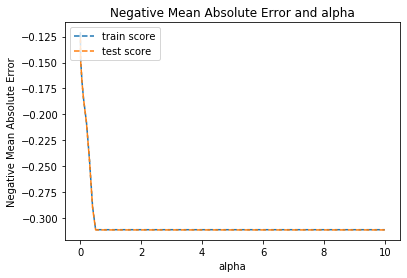

In [211]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], linestyle='--')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], linestyle='--')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [212]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [213]:
lasso.coef_

array([ 0.10955687,  0.12717172,  0.11622467, -0.16543276, -0.04973808,
       -0.19323156,  0.52364343,  0.4499515 ,  0.46316421,  0.3604887 ,
        0.16339335,  0.23443601,  0.12025884,  0.11753763,  0.11606828,
        0.34818129, -0.32038243,  0.12745671,  0.18112195, -0.12799972,
       -0.09658984, -0.09790773, -0.26130288, -0.01157985,  0.11562489,
       -0.00069664, -0.12082113,  0.1609478 , -0.21965668, -0.1921375 ])

In [214]:
# predict prices of X_train
y_train_pred = lasso.predict(X_train)
r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
print(r2)

0.8373558012698497


#### Lasso Regression - We got a R-squared value of 0.83 for Train dataset

## Residual analysis 
To validate assumptions of the model, and hence the reliability for inference
#### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

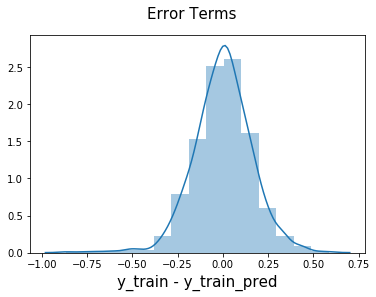

In [215]:
res = (y_train - y_train_pred)

fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

The residuals are little left skewed but following the normally distributed with a mean almost 0.

### Predictions on the Test Set

In [216]:
X_test = X_test[col]

# predict prices of X_test
y_pred = lasso.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.8311647331218135


#### We got a R-squared value of 0.83 for Lasso Regression

### Lasso - Features and their coefficient

In [217]:
lassofeatures = list(zip(col, lasso.coef_))
lassofeatures = [col for col in lassofeatures if col[1] != 0]
lassofeatures = pd.DataFrame(lassofeatures,columns=['Column','Coefficient'])
lassofeatures = lassofeatures.sort_values(by=['Coefficient'], ascending=False)
lassofeatures

,Column,Coefficient
6,MSZoning_FV,0.523643
8,MSZoning_RL,0.463164
7,MSZoning_RH,0.449951
9,MSZoning_RM,0.360489
15,RoofStyle_Shed,0.348181
11,Neighborhood_NoRidge,0.234436
18,Exterior1st_Stone,0.181122
10,Neighborhood_Crawfor,0.163393
27,CentralAir_Y,0.160948
17,Exterior1st_BrkFace,0.127457


### Ridge - Features and their coefficient

In [218]:
ridgefeatures = list(zip(col, ridge.coef_))
ridgefeatures = pd.DataFrame(lassofeatures,columns=['Column','Coefficient'])
ridgefeatures = ridgefeatures.sort_values(by=['Coefficient'], ascending=False)
ridgefeatures

,Column,Coefficient
6,MSZoning_FV,0.523643
8,MSZoning_RL,0.463164
7,MSZoning_RH,0.449951
9,MSZoning_RM,0.360489
15,RoofStyle_Shed,0.348181
11,Neighborhood_NoRidge,0.234436
18,Exterior1st_Stone,0.181122
10,Neighborhood_Crawfor,0.163393
27,CentralAir_Y,0.160948
17,Exterior1st_BrkFace,0.127457


### Plot for significant features

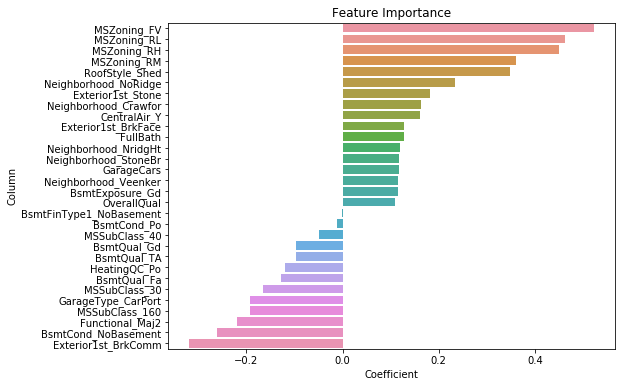

In [219]:
# Plot feature importance based on Lasso Result
plt.figure(figsize=(8,6))
sns.barplot(x= 'Coefficient',y = 'Column',data = lassofeatures)
plt.title("Feature Importance")
plt.show()

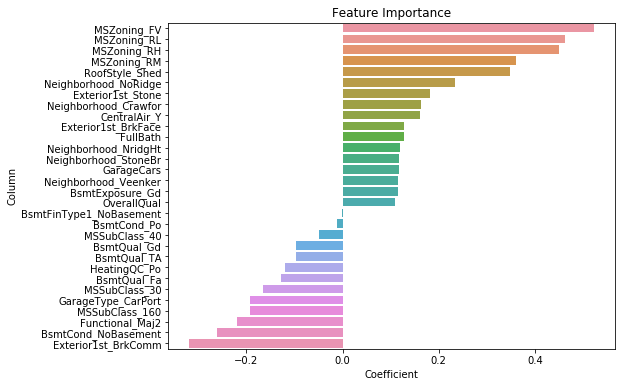

In [220]:
# Plot feature importance based on Ridge Result
plt.figure(figsize=(8,6))
sns.barplot(x= 'Coefficient',y = 'Column',data = ridgefeatures)
plt.title("Feature Importance")
plt.show()

### Summary
The company wants to know:

#### Which variables are significant in predicting the price of a house ?

##### Top Features to be considered are
1. Houses having MSZoning as Floating Village Residential, Residential High Density,Residential Medium Density, Residential Low Density
2. Houses having RoofStyle as Shed
3. Neighborhood : Northridge & Crawford
4. Exterior covering on house to be stone.
5. Houses with Central Air

#### How well those variables describe the price of a house ?

##### Train Data :
1. Ridge R-Squared prediction : 0.84 
2. Lasso R-Squared prediction : 0.83

##### Test Data :
1. Ridge R-Squared prediction : 0.83 
2. Lasso R-Squared prediction : 0.83

Approximately we are able to explain about 83% variance of the price of a house. 

### Optimised Alpha Value for both ridge and lasso is 0.0001